In [88]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from rasterio.features import geometry_mask, shapes
from rasterio.plot import show
from rasterio.windows import Window, from_bounds
from shapely.geometry import Polygon, box
from shapely.ops import transform as shapely_transform
from rasterio.warp import transform_bounds, Resampling, reproject
from rasterio.transform import from_origin
from rasterio.crs import CRS
import matplotlib.pyplot as plt
import numpy as np
#import ee
import pyproj
from datetime import datetime
import os
from PIL import Image

In [89]:
RESOLUTION = 1000

## Colorado River Basin and US Rasters

In [ ]:
# Display the US raster
usa_fp = "USA_1km_raster.tif"
usa = rasterio.open(usa_fp)
fig, ax = plt.subplots()

extent = [usa.bounds[0], usa.bounds[2], usa.bounds[1], usa.bounds[3]]
ax = rasterio.plot.show(usa, extent=extent, ax=ax, cmap="pink")

## Auxillary Functions

alot of boilerplate rasterio functions

In [91]:
# helper function to display raster with a downscale factor
def show_raster(raster_path, downscale=None):
    raster = rasterio.open(raster_path)
    image = raster.read(1)

    if downscale:
        image = raster.read(1)[::downscale]

    fig, ax = plt.subplots()

    extent = [raster.bounds[0], raster.bounds[2], raster.bounds[1], raster.bounds[3]]
    ax = rasterio.plot.show(image, ax=ax, extent=extent)

In [92]:
# reproject a raster to another raster
# (used to reproject all data layers to CRB raster projection)
def reproject_raster_to_target(input_raster_path, target_raster_path, output_raster_path):
    with rasterio.open(input_raster_path) as src:
        with rasterio.open(target_raster_path) as target:
            # get and update raster's metadata
            target_crs = target.crs
            target_transform = target.transform
            target_meta = target.meta.copy()

            target_meta.update({
                'crs': target_crs,
                'transform': target_transform,
                'driver': 'GTiff',
                'count': src.count,
                'width': target.width,
                'height': target.height,
            })

            with rasterio.open(output_raster_path, 'w', **target_meta) as dest:
                # reproject each band of the raster
                for i in range(1, src.count + 1):
                    reproject(
                        source=rasterio.band(src, i),
                        destination=rasterio.band(dest, i),
                        src_transform=src.transform,
                        src_crs=src.crs,
                        dst_transform=target_transform,
                        dst_crs=target_crs,
                        resampling=Resampling.nearest
                    )

In [93]:
# clip (or crop) a raster given a mask raster
# (used to crop the datalayers with the CRB's boundary)

def clip_with_raster(mask_raster_path, data_raster_path, out_raster_path):
    with rasterio.open(mask_raster_path) as raster_a:
        bounds_a = raster_a.bounds
        crs_a = raster_a.crs

    with rasterio.open(data_raster_path) as raster_b:
        crs_b = raster_b.crs
        bounds_in_b_crs = transform_bounds(crs_a, crs_b, *bounds_a)

    # get the CRB's boudning box
    bbox_geom = [box(*bounds_in_b_crs)]
    
    with rasterio.open(data_raster_path) as raster_b:
        # crop the input raster with the CRB's bounds
        clipped, clipped_transform = mask(raster_b, bbox_geom, crop=True)

        # update the meta data
        clipped_meta = raster_b.meta.copy()
        clipped_meta.update({
            "driver": "GTiff",
            "height": clipped.shape[1],
            "width": clipped.shape[2],
            "transform": clipped_transform
        })

        # write the new file
        with rasterio.open(out_raster_path, "w", **clipped_meta) as dest:
            dest.write(clipped)

## Process Data Layers

### Land Use Land Cover
*MRLC*<br>
https://www.mrlc.gov/data?f%5B0%5D=category%3ALand%20Cover<br>
30m, 1985-2023<br>

In [94]:
# LULC PASTURE

# process each LULC datalayer year
def process_mrlc_pasture_file(usa_fp, mrlc_file, output_file):
    clip_with_raster(usa_fp, mrlc_file, "temp_clipped.tif")
    reproject_raster_to_target("temp_clipped.tif", usa_fp, "temp_reprojected.tif")

    with rasterio.open("temp_reprojected.tif") as src:
        data = src.read(1)
        meta = src.meta

    with rasterio.open(usa_fp) as usa:
        mask = usa.read(1)

    # Since this raster is already binary (0/1), just apply USA mask
    data_masked = np.where(mask != 0, data, 0).astype("uint8")

    meta.update(dtype="uint8", nodata=0)

    with rasterio.open(output_file, "w", **meta) as dest:
        dest.write(data_masked[np.newaxis, :, :])

def batch_process_mrlc_pasture(usa_fp, mrlc_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for mrlc_file in os.listdir(mrlc_folder):
        if mrlc_file.endswith(".tif"):
            input_file = os.path.join(mrlc_folder, mrlc_file)
            output_file = os.path.join(output_folder, f"{mrlc_file[:-4]}_processed.tif")
            print("Processing:", input_file)
            process_mrlc_pasture_file(usa_fp, input_file, output_file)

usa_fp = "USA_1km_raster.tif"
batch_process_mrlc_pasture(usa_fp, "./mrlc/", "./processed_mrlc_pasture/")

with rasterio.open("./processed_mrlc_pasture/mrlc_pasture_2000_1km_processed.tif") as ds:
    arr = ds.read(1)

Processing: ./mrlc/mrlc_pasture_2000_1km.tif
Processing: ./mrlc/mrlc_pasture_2001_1km.tif
Processing: ./mrlc/mrlc_pasture_2002_1km.tif
Processing: ./mrlc/mrlc_pasture_2003_1km.tif
Processing: ./mrlc/mrlc_pasture_2004_1km.tif
Processing: ./mrlc/mrlc_pasture_2005_1km.tif
Processing: ./mrlc/mrlc_pasture_2006_1km.tif
Processing: ./mrlc/mrlc_pasture_2007_1km.tif
Processing: ./mrlc/mrlc_pasture_2008_1km.tif
Processing: ./mrlc/mrlc_pasture_2009_1km.tif
Processing: ./mrlc/mrlc_pasture_2010_1km.tif
Processing: ./mrlc/mrlc_pasture_2011_1km.tif
Processing: ./mrlc/mrlc_pasture_2012_1km.tif
Processing: ./mrlc/mrlc_pasture_2013_1km.tif
Processing: ./mrlc/mrlc_pasture_2014_1km.tif
Processing: ./mrlc/mrlc_pasture_2015_1km.tif
Processing: ./mrlc/mrlc_pasture_2016_1km.tif
Processing: ./mrlc/mrlc_pasture_2017_1km.tif
Processing: ./mrlc/mrlc_pasture_2018_1km.tif
Processing: ./mrlc/mrlc_pasture_2019_1km.tif
Processing: ./mrlc/mrlc_pasture_2020_1km.tif
Processing: ./mrlc/mrlc_pasture_2021_1km.tif
Processing

### Allotment
*Allotment data from the Rangeland Management data set*<br>
*The Allotment feature class designates boundaries to establish extent of livestock distribution and management within the allotment*<br>
https://data.fs.usda.gov/geodata/edw/datasets.php?xmlKeyword=livestock<br>
1km, 2008-2025

In [100]:
# allotment

# process each allotment raster year
def process_allotment_file(usa_fp, allot_file, output_file):
    # clip the raster with the usa’s bounds for memory efficiency
    clip_with_raster(usa_fp, allot_file, "temp_clipped.tif")
    # reproject the raster to the usa’s projection
    reproject_raster_to_target("temp_clipped.tif", usa_fp, "temp_reprojected.tif")

    with rasterio.open("temp_reprojected.tif") as allot_raster:
        allot_data = allot_raster.read(1)
        allot_meta = allot_raster.meta

    with rasterio.open(usa_fp) as usa:
        usa_data = usa.read(1)

    # update allotment specific meta data
    allot_meta["dtype"] = "uint8"     # since it’s just 0/1 mask
    allot_meta["nodata"] = 0          # no allotment = 0

    # mask values outside usa
    allot_data_masked = np.where(usa_data != 0, allot_data, allot_meta["nodata"])

    with rasterio.open(output_file, "w", **allot_meta) as dest:
        dest.write(allot_data_masked[np.newaxis, :, :])


# batch process all allotment years
def batch_process_allotment(usa_fp, allot_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for allot_file in os.listdir(allot_folder):
        print(allot_file)
        if allot_file.endswith(".tif"):
            input_file = os.path.join(allot_folder, allot_file)
            output_file = os.path.join(output_folder, f"{allot_file[:-4]}_processed.tif")
            process_allotment_file(usa_fp, input_file, output_file)


# Example usage
usa_fp = "USA_1km_raster.tif"
batch_process_allotment(usa_fp, "./allotment/", "./processed_allotment/")


.ipynb_checkpoints
allotment_2000.tif
allotment_2001.tif
allotment_2002.tif
allotment_2003.tif
allotment_2004.tif
allotment_2005.tif
allotment_2006.tif
allotment_2007.tif
allotment_2008.tif
allotment_2009.tif
allotment_2010.tif
allotment_2011.tif
allotment_2012.tif
allotment_2013.tif
allotment_2014.tif
allotment_2015.tif
allotment_2016.tif
allotment_2017.tif
allotment_2018.tif
allotment_2019.tif
allotment_2020.tif


### Pasture
*Range: Unit Pasture*<br>
*Pasture is a feature class in the Rangeland Management data set. It represents the area boundaries of livestock grazing pastures*<br>
https://catalog.data.gov/dataset/range-unit-pasture-3ac93<br>
1km, 2008-2025

In [101]:
# pasture

# process each pasture datalayer year
def process_pasture_file(usa_fp, pasture_file, output_file):
    # clip to usa
    clip_with_raster(usa_fp, pasture_file, "temp_clipped.tif")
    # reproject
    reproject_raster_to_target("temp_clipped.tif", usa_fp, "temp_reprojected.tif")

    with rasterio.open("temp_reprojected.tif") as src:
        data = src.read(1)
        meta = src.meta

    with rasterio.open(usa_fp) as usa:
        mask = usa.read(1)

    # ensure binary mask (pasture presence/absence)
    data_masked = np.where(mask != 0, data, 0).astype("uint8")

    meta.update(dtype="uint8", nodata=0)

    with rasterio.open(output_file, "w", **meta) as dest:
        dest.write(data_masked[np.newaxis, :, :])


def batch_process_pasture(usa_fp, pasture_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for pasture_file in os.listdir(pasture_folder):
        if pasture_file.endswith(".tif"):
            input_file = os.path.join(pasture_folder, pasture_file)
            output_file = os.path.join(output_folder, f"{pasture_file[:-4]}_processed.tif")
            print("Processing:", input_file)
            process_pasture_file(usa_fp, input_file, output_file)

usa_fp = "USA_1km_raster.tif"
batch_process_pasture(usa_fp, "./pasture_presence/", "./processed_pasture/")


Processing: ./pasture_presence/pasture_presence_2000.tif
Processing: ./pasture_presence/pasture_presence_2001.tif
Processing: ./pasture_presence/pasture_presence_2002.tif
Processing: ./pasture_presence/pasture_presence_2003.tif
Processing: ./pasture_presence/pasture_presence_2004.tif
Processing: ./pasture_presence/pasture_presence_2005.tif
Processing: ./pasture_presence/pasture_presence_2006.tif
Processing: ./pasture_presence/pasture_presence_2007.tif
Processing: ./pasture_presence/pasture_presence_2008.tif
Processing: ./pasture_presence/pasture_presence_2009.tif
Processing: ./pasture_presence/pasture_presence_2010.tif
Processing: ./pasture_presence/pasture_presence_2011.tif
Processing: ./pasture_presence/pasture_presence_2012.tif
Processing: ./pasture_presence/pasture_presence_2013.tif
Processing: ./pasture_presence/pasture_presence_2014.tif
Processing: ./pasture_presence/pasture_presence_2015.tif
Processing: ./pasture_presence/pasture_presence_2016.tif
Processing: ./pasture_presence/

### Poultry, Dairy, Livestock, Cattle
*USDA Quick Stats*<br>
https://quickstats.nass.usda.gov/<br>
Poultry: county, 1997, 2002, 2007, 2012, 2017, and 2022<br>
Dairy: state, 2000-2020<br>
Livestock: county, 2007, 2012, 2017<br>
Cattle: county, 2002, 2007, 2012, 2017, and 2022<br>

In [102]:
# imports
import geopandas as gpd
import pandas as pd
import rasterio
from rasterio.features import rasterize
import numpy as np
import os
from sklearn.linear_model import LinearRegression

def process_usda_data(csv_path, county_shp, template_tif, output_dir, commodity_type):
    
    # load raster template (USA_1km_raster.tif)
    with rasterio.open(template_tif) as src:
        meta = src.meta.copy()
        meta.update(dtype="float32", count=1) 
        transform = src.transform
        width, height = src.width, src.height
        crs = src.crs
        out_shape = (height, width)
    
    # read county shape file
    gdf = gpd.read_file(county_shp)
    if gdf.crs is None:
        gdf.set_crs(epsg=4326, inplace=True)
    gdf = gdf.to_crs(crs)
    gdf["GEOID"] = gdf["STATEFP"] + gdf["COUNTYFP"]
    gdf["area_km2"] = gdf.geometry.to_crs(3857).area / 1e6
    
    # read county shape file
    df = pd.read_csv(csv_path, dtype=str)
    df["Value"] = (
        df["Value"]
        .astype(str)
        .str.replace(",", "", regex=False)
        .str.replace(" ", "", regex=False)
        .replace({"(D)": "0", "(Z)": "0", "(NA)": "0", "(X)": "0", "-": "0"})
        .astype(float)
    )
    df.columns = df.columns.str.strip()
    
    # build GEOID and clean
    df["State ANSI"] = (df["State ANSI"].fillna("").astype(str).str.replace(".0", "", regex=False).str.zfill(2))
    df["County ANSI"] = (df["County ANSI"].fillna("").astype(str).str.replace(".0", "", regex=False).str.zfill(3))
    df["GEOID"] = df["State ANSI"] + df["County ANSI"]
    
    # make sure that both datasets use same zero padded string format
    gdf["GEOID"] = gdf["GEOID"].astype(str).str.zfill(5)
    
    # remove invalid / national rows
    if "Geo Level" in df.columns:
        df = df[df["Geo Level"].str.upper() == "COUNTY"]
    
    # clean Value column
    df["Value"] = pd.to_numeric(df["Value"], errors="coerce")
    df = df.dropna(subset=["Value"])
    
    # keep relevant columns
    df = df[["Year", "GEOID", "Value"]]
    
    # aggregate in case of multiple entries in a county in the same year
    df = df.groupby(["GEOID", "Year"], as_index=False)["Value"].sum()
    
    # pivot to year matrix
    pivot = df.pivot(index="GEOID", columns="Year", values="Value")
    
    
    # define known years and years to output
    known_years = pivot.columns.values
    pred_years = np.arange(2000, 2021)  # we want only 2000–2020
    
    # regression per county
    pred_table = pd.DataFrame(index=pivot.index, columns=pred_years)
    for geoid, row in pivot.iterrows():
        y = row.dropna()
        if len(y) >= 2:
            x = y.index.values.reshape(-1, 1)
            model = LinearRegression().fit(x, y)
            preds = model.predict(pred_years.reshape(-1, 1))
            pred_table.loc[geoid] = preds
        elif len(y) == 1:
            pred_table.loc[geoid] = float(y.iloc[0])
        else:
            pred_table.loc[geoid] = 0.0
    
    # rasterize each year
    for year in pred_years:
        # get dairy density
        vals = pred_table[year].astype(float).fillna(0).reset_index()
        merged = gdf.merge(vals, on="GEOID", how="left")
        merged["density"] = (merged[year] / merged["area_km2"]).astype(float)
    
        # make sure there are no negatives
        merged["density"] = merged["density"].clip(lower=0)
    
        # prepare shapes for rasterization
        shapes = ((geom, val) for geom, val in zip(merged.geometry, merged["density"].fillna(0)))
    
        # rasterize
        raster = rasterize(
            shapes=shapes,
            out_shape=out_shape,
            transform=transform,
            fill=0,
            # make sure raster values are floats
            dtype="float32"
        )
    
        # output as commodity_20xx.tif to poultry_rasters_regressed
        out_path = os.path.join(output_dir, f"{commodity_type}_{year}.tif")
        with rasterio.open(out_path, "w", **meta) as dst:
            dst.write(raster, 1)
    
        print(f"Saved {out_path}")


In [103]:
# USDA POULTRY
# get file paths for input/output/templates
csv_data_path = "input_files/all_poultry_data.csv"
us_shp_files_file = "us_shp_files/tl_2024_us_county.shp"
template_tif_file = "USA_1km_raster.tif"
output_directory = "usda_poultry_rasters_regressed"
os.makedirs(output_directory, exist_ok=True)
commodity_type = "poultry"

# call processing function for poultry
process_usda_data(csv_data_path, us_shp_files_file, template_tif_file, output_directory, commodity_type)

Saved usda_poultry_rasters_regressed\poultry_2000.tif
Saved usda_poultry_rasters_regressed\poultry_2001.tif
Saved usda_poultry_rasters_regressed\poultry_2002.tif
Saved usda_poultry_rasters_regressed\poultry_2003.tif
Saved usda_poultry_rasters_regressed\poultry_2004.tif
Saved usda_poultry_rasters_regressed\poultry_2005.tif
Saved usda_poultry_rasters_regressed\poultry_2006.tif
Saved usda_poultry_rasters_regressed\poultry_2007.tif
Saved usda_poultry_rasters_regressed\poultry_2008.tif
Saved usda_poultry_rasters_regressed\poultry_2009.tif
Saved usda_poultry_rasters_regressed\poultry_2010.tif
Saved usda_poultry_rasters_regressed\poultry_2011.tif
Saved usda_poultry_rasters_regressed\poultry_2012.tif
Saved usda_poultry_rasters_regressed\poultry_2013.tif
Saved usda_poultry_rasters_regressed\poultry_2014.tif
Saved usda_poultry_rasters_regressed\poultry_2015.tif
Saved usda_poultry_rasters_regressed\poultry_2016.tif
Saved usda_poultry_rasters_regressed\poultry_2017.tif
Saved usda_poultry_rasters_r

In [104]:
# USDA LIVESTOCK
# get file paths for input/output/templates
csv_data_path = "input_files/livestock_all.csv"
us_shp_files_file = "us_shp_files/tl_2024_us_county.shp"
template_tif_file = "USA_1km_raster.tif"
output_directory = "usda_livestock_rasters_regressed"
os.makedirs(output_directory, exist_ok=True)
commodity_type = "livestock"

# call processing function for livestock
process_usda_data(csv_data_path, us_shp_files_file, template_tif_file, output_directory, commodity_type)

Saved usda_livestock_rasters_regressed\livestock_2000.tif
Saved usda_livestock_rasters_regressed\livestock_2001.tif
Saved usda_livestock_rasters_regressed\livestock_2002.tif
Saved usda_livestock_rasters_regressed\livestock_2003.tif
Saved usda_livestock_rasters_regressed\livestock_2004.tif
Saved usda_livestock_rasters_regressed\livestock_2005.tif
Saved usda_livestock_rasters_regressed\livestock_2006.tif
Saved usda_livestock_rasters_regressed\livestock_2007.tif
Saved usda_livestock_rasters_regressed\livestock_2008.tif
Saved usda_livestock_rasters_regressed\livestock_2009.tif
Saved usda_livestock_rasters_regressed\livestock_2010.tif
Saved usda_livestock_rasters_regressed\livestock_2011.tif
Saved usda_livestock_rasters_regressed\livestock_2012.tif
Saved usda_livestock_rasters_regressed\livestock_2013.tif
Saved usda_livestock_rasters_regressed\livestock_2014.tif
Saved usda_livestock_rasters_regressed\livestock_2015.tif
Saved usda_livestock_rasters_regressed\livestock_2016.tif
Saved usda_liv

In [105]:
# USDA CATTLE
# get file paths for input/output/templates
csv_data_path = "input_files/cattle_usda.csv"
us_shp_files_file = "us_shp_files/tl_2024_us_county.shp"
template_tif_file = "USA_1km_raster.tif"
output_directory = "usda_cattle_usda_rasters_regressed"
os.makedirs(output_directory, exist_ok=True)
commodity_type = "cattle_usda"

# call processing function for cattle land
process_usda_data(csv_data_path, us_shp_files_file, template_tif_file, output_directory, commodity_type)

Saved usda_cattle_usda_rasters_regressed\cattle_usda_2000.tif
Saved usda_cattle_usda_rasters_regressed\cattle_usda_2001.tif
Saved usda_cattle_usda_rasters_regressed\cattle_usda_2002.tif
Saved usda_cattle_usda_rasters_regressed\cattle_usda_2003.tif
Saved usda_cattle_usda_rasters_regressed\cattle_usda_2004.tif
Saved usda_cattle_usda_rasters_regressed\cattle_usda_2005.tif
Saved usda_cattle_usda_rasters_regressed\cattle_usda_2006.tif
Saved usda_cattle_usda_rasters_regressed\cattle_usda_2007.tif
Saved usda_cattle_usda_rasters_regressed\cattle_usda_2008.tif
Saved usda_cattle_usda_rasters_regressed\cattle_usda_2009.tif
Saved usda_cattle_usda_rasters_regressed\cattle_usda_2010.tif
Saved usda_cattle_usda_rasters_regressed\cattle_usda_2011.tif
Saved usda_cattle_usda_rasters_regressed\cattle_usda_2012.tif
Saved usda_cattle_usda_rasters_regressed\cattle_usda_2013.tif
Saved usda_cattle_usda_rasters_regressed\cattle_usda_2014.tif
Saved usda_cattle_usda_rasters_regressed\cattle_usda_2015.tif
Saved us

In [106]:
# imports
import geopandas as gpd
import pandas as pd
import rasterio
from rasterio.features import rasterize
import numpy as np
import os
from sklearn.linear_model import LinearRegression

# get file paths for input/output/templates
csv_path = "input_files/dairy_data.csv"
state_shp = "us_shp_files/tl_2020_us_state.shp"
template_tif = "USA_1km_raster.tif"
output_dir = "usda_dairy_rasters_regressed"
os.makedirs(output_dir, exist_ok=True)
livestock_type = "dairy"

# load raster template (USA_1km_raster.tif)
with rasterio.open(template_tif) as src:
    meta = src.meta.copy()
    meta.update(dtype="float32", count=1)
    transform = src.transform
    width, height = src.width, src.height
    crs = src.crs
    out_shape = (height, width)

# read state shape file
gdf = gpd.read_file(state_shp)
if gdf.crs is None:
    gdf.set_crs(epsg=4326, inplace=True)
gdf = gdf.to_crs(crs)
gdf["STATEFP"] = gdf["STATEFP"].astype(str).str.zfill(2)
gdf["area_km2"] = gdf.geometry.to_crs(3857).area / 1e6

# clean data
df = pd.read_csv(csv_path, dtype=str)
df.columns = df.columns.str.strip()

# build GEOID and clean
df["State ANSI"] = (df["State ANSI"].fillna("").astype(str).str.replace(".0", "", regex=False).str.zfill(2))
df["GEOID"] = df["State ANSI"]

# make sure that both datasets use same zero padded string format
gdf["GEOID"] = gdf["GEOID"].astype(str).str.zfill(5)

# remove invalid / national rows
if "Geo Level" in df.columns:
    df = df[df["Geo Level"].str.upper().str.strip() == "STATE"]

# clean Value column
df["Value"] = pd.to_numeric(df["Value"], errors="coerce")
df = df.dropna(subset=["Value"])

# keep relevant columns
df = df[["Year", "GEOID", "Value"]]

# aggregate in case of multiple entries in a county in the same year
df = df.groupby(["GEOID", "Year"], as_index=False)["Value"].sum()

# pivot to year matrix
pivot = df.pivot(index="GEOID", columns="Year", values="Value")

# define known years and years to output
known_years = pivot.columns.values
pred_years = np.arange(2000, 2021)

# regression per county
pred_table = pd.DataFrame(index=pivot.index, columns=pred_years)
for geoid, row in pivot.iterrows():
    y = row.dropna()
    if len(y) >= 2:
        x = y.index.values.reshape(-1, 1)
        model = LinearRegression().fit(x, y)
        preds = model.predict(pred_years.reshape(-1, 1))
        pred_table.loc[geoid] = preds
    elif len(y) == 1:
        pred_table.loc[geoid] = float(y.iloc[0])
    else:
        pred_table.loc[geoid] = 0.0

# rasterize each year
for year in pred_years:
    vals = pred_table[year].astype(float).fillna(0).reset_index()
    merged = gdf.merge(vals, left_on="STATEFP", right_on="GEOID", how="left")
    
    # get dairy density
    merged["density"] = (merged[year] / merged["area_km2"]).astype(float)
    merged["density"] = merged["density"].clip(lower=0)
    
    # prepare shapes for rasterization
    shapes = ((geom, val) for geom, val in zip(merged.geometry, merged["density"].fillna(0)))

    # rasterize
    raster = rasterize(
        shapes=shapes,
        out_shape=out_shape,
        transform=transform,
        fill=0,
        # make sure raster values are floats
        dtype="float32"
    )

    # output as livestock_type_20xx.tif to poultry_rasters_regressed
    out_path = os.path.join(output_dir, f"{livestock_type}_{year}.tif")
    with rasterio.open(out_path, "w", **meta) as dst:
        dst.write(raster, 1)

    print(f"Saved {out_path}")

Saved usda_dairy_rasters_regressed\dairy_2000.tif
Saved usda_dairy_rasters_regressed\dairy_2001.tif
Saved usda_dairy_rasters_regressed\dairy_2002.tif
Saved usda_dairy_rasters_regressed\dairy_2003.tif
Saved usda_dairy_rasters_regressed\dairy_2004.tif
Saved usda_dairy_rasters_regressed\dairy_2005.tif
Saved usda_dairy_rasters_regressed\dairy_2006.tif
Saved usda_dairy_rasters_regressed\dairy_2007.tif
Saved usda_dairy_rasters_regressed\dairy_2008.tif
Saved usda_dairy_rasters_regressed\dairy_2009.tif
Saved usda_dairy_rasters_regressed\dairy_2010.tif
Saved usda_dairy_rasters_regressed\dairy_2011.tif
Saved usda_dairy_rasters_regressed\dairy_2012.tif
Saved usda_dairy_rasters_regressed\dairy_2013.tif
Saved usda_dairy_rasters_regressed\dairy_2014.tif
Saved usda_dairy_rasters_regressed\dairy_2015.tif
Saved usda_dairy_rasters_regressed\dairy_2016.tif
Saved usda_dairy_rasters_regressed\dairy_2017.tif
Saved usda_dairy_rasters_regressed\dairy_2018.tif
Saved usda_dairy_rasters_regressed\dairy_2019.tif


## Data Visualization

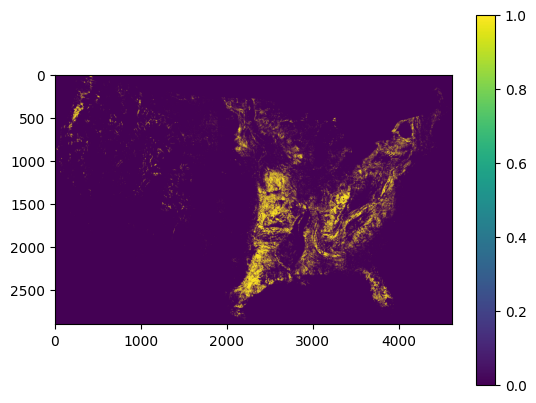

In [107]:
import rasterio
import matplotlib.pyplot as plt

fp = "processed_mrlc_pasture/mrlc_pasture_2000_1km_processed.tif"
with rasterio.open(fp) as src:
    arr = src.read(1)
    plt.imshow(arr, cmap="viridis")
    plt.colorbar()
    plt.show()

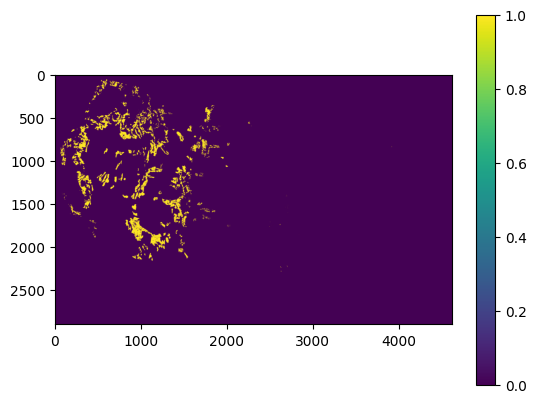

In [108]:
import rasterio
import matplotlib.pyplot as plt

fp = "processed_allotment/allotment_2000_processed.tif"
with rasterio.open(fp) as src:
    arr = src.read(1)
    plt.imshow(arr, cmap="viridis")
    plt.colorbar()
    plt.show()

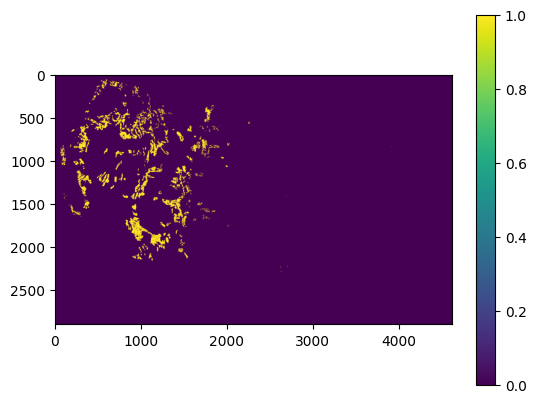

In [109]:
import rasterio
import matplotlib.pyplot as plt

fp = "pasture_presence/pasture_presence_2000.tif"
with rasterio.open(fp) as src:
    arr = src.read(1)
    plt.imshow(arr, cmap="viridis")
    plt.colorbar()
    plt.show()

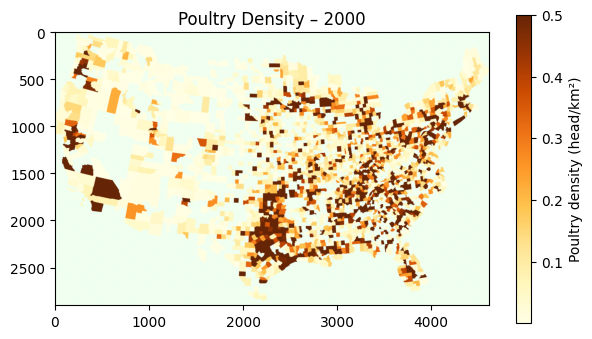

In [110]:
import rasterio
import matplotlib.pyplot as plt

fp = "usda_poultry_rasters_regressed/poultry_2002.tif"
with rasterio.open(fp) as src:
    arr = src.read(1)
    cmap = plt.cm.YlOrBr.copy()
    cmap.set_under(color="HoneyDew")
    plt.figure(figsize=(7,4))
    plt.imshow(arr, cmap=cmap, vmin=0.001, vmax=.5)
    plt.colorbar(label="Poultry density (head/km²)")
    plt.title("Poultry Density – 2000")
    plt.show()

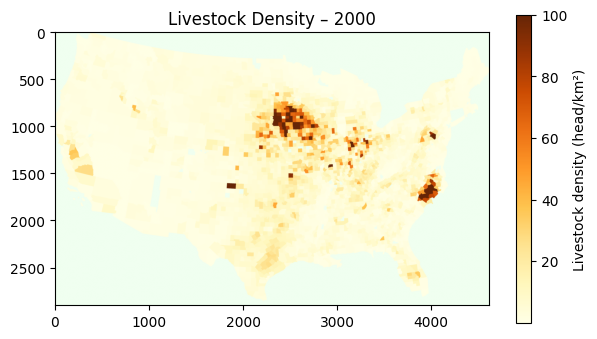

In [111]:
import rasterio
import matplotlib.pyplot as plt

fp = "usda_livestock_rasters_regressed/livestock_2000.tif"
with rasterio.open(fp) as src:
    arr = src.read(1)
    cmap = plt.cm.YlOrBr.copy()
    cmap.set_under(color="HoneyDew")
    plt.figure(figsize=(7,4))
    plt.imshow(arr, cmap=cmap, vmin=0.001, vmax=100)
    plt.colorbar(label="Livestock density (head/km²)")
    plt.title("Livestock Density – 2000")
    plt.show()

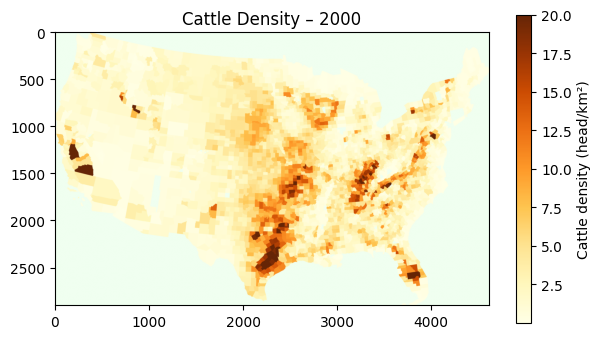

In [112]:
import rasterio
import matplotlib.pyplot as plt

fp = "usda_cattle_usda_rasters_regressed/cattle_usda_2000.tif"
with rasterio.open(fp) as src:
    arr = src.read(1)
    cmap = plt.cm.YlOrBr.copy()
    cmap.set_under(color="HoneyDew")
    plt.figure(figsize=(7,4))
    plt.imshow(arr, cmap=cmap, vmin=0.001, vmax=20)
    plt.colorbar(label="Cattle density (head/km²)")
    plt.title("Cattle Density – 2000")
    plt.show()

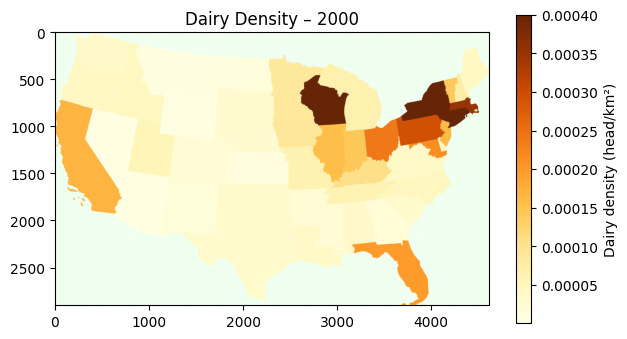

In [82]:
import rasterio
import matplotlib.pyplot as plt

fp = "usda_dairy_rasters_regressed/dairy_2000.tif"
with rasterio.open(fp) as src:
    arr = src.read(1)
    cmap = plt.cm.YlOrBr.copy()
    cmap.set_under(color="HoneyDew")
    plt.figure(figsize=(7,4))
    plt.imshow(arr, cmap=cmap, vmin=0.000001, vmax=.0004)
    plt.colorbar(label="Dairy density (head/km²)")
    plt.title("Dairy Density – 2000")
    plt.show()